# Estimativa preços de venda do dataset Boston_housing

Um dos problemas clássicos de machine learning é a previsão dos preços das casas de Boston apresentado no final da década de 1970.

Existe uma competição no Kaggle que utiliza este dataset:
https://www.kaggle.com/c/boston-housing

O objetivo desse notebook é fazer a previsão dos preços das casas utilizando uma rede neural com uma camada escondida de 40 neurônios.


## Importação dos pacotes

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.autograd import Variable

import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Leitura do Dataset

Leitura do Dataset já normalizado: [boston_housing.ipynb](boston_housing.ipynb)
- **Atenção**: se houver erro em não achar o arquivo, executar o notebook boston_housing.ipynb

In [29]:
datain = np.load('../data/boston_housing_normalize.npz')

x, y = datain['Xtra'], datain['ytra']

In [30]:
n_samples, n_attributes = x.shape
print('n_samples:', n_samples)
print('n_attributes:', n_attributes)

n_samples: 506
n_attributes: 13


### Conversão para Tensor

In [7]:
x_train = torch.FloatTensor(x)
y_train = torch.FloatTensor(y)

## Rede, uma camada escondida de 40 neurônios

In [44]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(n_attributes, 40)
        self.ativ1  = nn.ReLU()
        self.layer2 = nn.Linear(40, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.ativ1(x)
        x = self.layer2(x)
        return x

model = Model()
if use_gpu:
    model.cuda()
model

Model (
  (layer1): Linear (13 -> 40)
  (ativ1): ReLU ()
  (layer2): Linear (40 -> 1)
)

## Parâmetros do otimizador

A escolha dos parâmetros para o treinamento é crítica. A escolha do learning rate,
do método de ótimização, do tamanho do mini-batch, do número de camadas, do número de neurônios em
cada camada, são todas críticas para o sucesso do estimador.

In [45]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, nesterov=True)
savebest = ptt.ModelCheckpoint('../../models/bostonhousing',reset=True, verbose=True)

trainer = ptt.DeepNetTrainer(
        model =         model,
        criterion =     criterion,
        optimizer =     optimizer,
        callbacks =     [savebest]
        #callbacks =     [PrintCallback()],
        )

## Treinamento

In [46]:
trainer.fit(100, x_train, y_train, valid_split=0.2, shuffle=True, batch_size=10)

Best model was saved at epoch 35 with loss 8.70391: ../../models/bostonhousing


## Avaliação

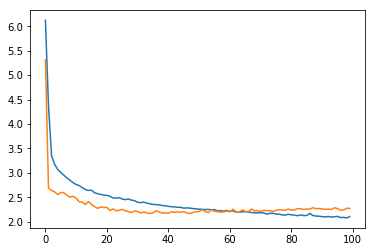

In [47]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, np.log(train_loss),
         epochs, np.log(valid_loss))

In [21]:
ptt.load_trainer_state('../../models/bostonhousing',trainer.model, trainer.metrics )

In [22]:
trainer.evaluate(x_train,y_train)

evaluate: 50/50 ok


{}

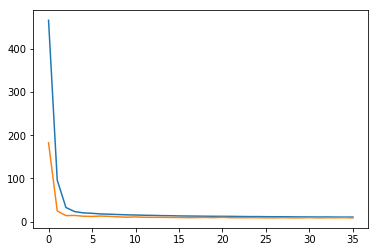

In [23]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss,
         epochs, valid_loss)

In [25]:
print('MSE:',valid_loss[-1])
print('RMSE:', np.sqrt(valid_loss[-1]))

MSE: 8.429780960083008
RMSE: 2.90340850727


# Exercícios

- Troque os hyperparâmetros para verificar se você consegue obter valores melhores. A forma de
  escolha e alteração de parâmetros é algo que se aprende com a experiência. Procure fazer
  sintonias finas, variando apenas um ou poucos parâmetros de cada vez.
  
  Parâmetros que podem ser trocados:
  - learning rate
  - n. de camadas
  - n. de neurônios
  - troca de função de ativação
  - método de otimizador do gradiente descendente
